In [3]:
import pandas as pd
import numpy as np 
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [4]:
fraud_df = pd.read_csv("data/fraud_data.csv")

In [5]:
fraud_df = fraud_df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

In [6]:
fraud_df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [7]:
fraud_df.describe()

,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [8]:
fraud_df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldBalanceOrig    0
newBalanceOrig    0
nameDest          0
oldBalanceDest    0
newBalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [9]:
# A step maps a unit of time in the real world. 
# In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

print("\nFraud:")
print(fraud_df.step[fraud_df.isFraud == 1].describe())
print("\nNormal:")
print(fraud_df.step[fraud_df.isFraud == 0].describe())


Fraud:
count    8213.000000
mean      368.413856
std       216.388690
min         1.000000
25%       181.000000
50%       367.000000
75%       558.000000
max       743.000000
Name: step, dtype: float64

Normal:
count    6.354407e+06
mean     2.432357e+02
std      1.421402e+02
min      1.000000e+00
25%      1.560000e+02
50%      2.390000e+02
75%      3.340000e+02
max      7.180000e+02
Name: step, dtype: float64


In [10]:
print('\nThe types of fraudulent transactions are either {}'.format(\
list(fraud_df.loc[fraud_df.isFraud == 1].type.drop_duplicates().values)))

print('\nTotal Fradulent transactions = {}'.\
     format(len(fraud_df[fraud_df.isFraud == 1])))
print("************************************")

transfer_fraud_df = fraud_df.loc[(fraud_df.isFraud == 1) & (fraud_df.type == 'TRANSFER')]
cashout_fraud_df = fraud_df.loc[(fraud_df.isFraud == 1) & (fraud_df.type == 'CASH_OUT')]

print('\nFradulent TRANSFER transactions = {}'.\
     format(len(transfer_fraud_df)))
print('\nFradudlent CASH_OUT transactions = {}'.\
     format(len(cashout_fraud_df)))



The types of fraudulent transactions are either ['TRANSFER', 'CASH_OUT']

Total Fradulent transactions = 8213
************************************

Fradulent TRANSFER transactions = 4097

Fradudlent CASH_OUT transactions = 4116


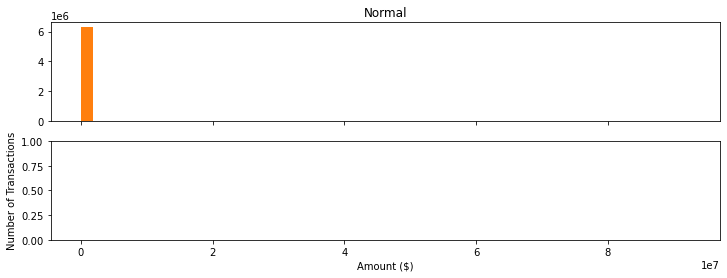

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize=(12,4))

bins = 50

ax1.hist(fraud_df.amount[fraud_df.isFraud == 1], bins = bins)
ax1.set_title("Fraud")

ax1.hist(fraud_df.amount[fraud_df.isFraud == 0], bins = bins)
ax1.set_title("Normal")

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.show()

In [12]:
#Create a new feature for normal (non-fraudulent) transactions.
fraud_df.loc[fraud_df.isFraud == 0, 'Normal'] = 1
fraud_df.loc[fraud_df.isFraud == 1, 'Normal'] = 0

In [13]:
fraud_df = fraud_df.rename(columns={'isFraud': 'Fraud'})
fraud_df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,Fraud,isFlaggedFraud,Normal
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,1.0


In [14]:
print(fraud_df.Normal.value_counts())
print()
print(fraud_df.Fraud.value_counts())

1.0    6354407
0.0       8213
Name: Normal, dtype: int64

0    6354407
1       8213
Name: Fraud, dtype: int64


In [15]:
Fraud = fraud_df[fraud_df.Fraud == 1]
Normal = fraud_df[fraud_df.Normal == 1]

In [16]:
X_train = Fraud.sample(frac=0.8)
count_Frauds = len(X_train)

X_train = pd.concat([X_train, Normal.sample(frac = 0.8)], axis = 0)

X_test = fraud_df.loc[~fraud_df.index.isin(X_train.index)]

In [17]:
X_train = shuffle(X_train)
X_test = shuffle(X_test)

In [18]:
y_train = X_train.Fraud
y_train = pd.concat([y_train, X_train.Normal], axis=1)

y_test = X_test.Fraud
y_test = pd.concat([y_test, X_test.Normal], axis=1)

In [19]:
X_train = X_train.drop(['Fraud','Normal'], axis = 1)
X_test = X_test.drop(['Fraud','Normal'], axis = 1)

In [20]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

5090096
5090096
1272524
1272524


In [21]:
ratio = len(X_train)/count_Frauds 

y_train.Fraud *= ratio
y_test.Fraud *= ratio

In [ ]:
features = X_train.columns.values

#Transform each feature in features so that it has a mean of 0 and standard deviation of 1; 
#this helps with training the neural network.
for feature in features:
    mean, std = fraud_df[feature].mean(), fraud_df[feature].std()
    X_train.loc[:, feature] = (X_train[feature] - mean) / std
    X_test.loc[:, feature] = (X_test[feature] - mean) / std